# Predicting number of days until a Department of Buildings Complaint is inspected

#### Authors:
- __Jeremy Ondov:__ [GitHub](https://github.com/ondovj)
- __Mahdi Shadkam-Farrokhi:__ [GitHub](https://github.com/Shaddyjr) 
---

## Problem Statement
In New York City, building violations are frequently reported to the Department of Buildings(DOB), which is often initiated by a citizen. However, the length of time between the report and a response by the DOB may vary greatly depending on the location, violation type, and other factors.

We'll be using $R^2$ for model selection.

## Executive Summary
...

## Table of Contents
1. 
2. [Resources](#Resources)


## Data Dictionary - [source](https://docs.google.com/spreadsheets/d/10p0HLqinKbUrSjKaZC2E0ZTHDXgULT0K/edit#gid=1015257717)
These data were cleaned from the original source using [the assocated cleaning notebook](./dob_data_cleaning.ipynb)

Column | Data Type | Description
- | - | :-
complaint_number |	integer |7-digit complaint number starting with borough code: (1= Manhattan, 2= Bronx, 3 = Brooklyn, 4 = Queens, 5 = Staten Island). This number is assigned by Buildings Information System (BIS) when the complaint is entered into the system.
status| string |Current status of the complaint. This is based on the Disposition Code.
date_entered|datetime|Date that the complaint was entered into BIS. 
house_number|integer|House number for the address of the building identified in the complaint.
zip_code|string|Zip code for the address of the building identified in the complaint.
house_street|string|Street name for the address of the building identified in the complaint.
special_district|string|Indicates whether or not the building identified in the complaint is located in a Special District.
unit|string|The most recent unit that was assigned to this complaint. It may have been initially assigned to one unit, and then referred to another unit for disposition.
inspection_date|datetime|Date that the inspection was performed.
days_until_inspection|integer|Number of days between when complaint was filed and when it was officially inspected

## Loading libraries and data


In [159]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import auto_arima

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import pickle

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

RANDOM_STATE = 12345

In [160]:
complaints = pd.read_csv('./datasets/cleaned.csv', index_col = 0, parse_dates = ["date_entered","inspection_date"])

In [161]:
complaints.head()

,complaint_number,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection
1,2193181,CLOSED,2013-12-17,573,10458,EAST FORDHAM ROAD,NOT SPECIAL,4B,SEP,2013-12-24,7
6,1265849,CLOSED,2009-09-21,429,10075,EAST 77 STREET,NOT SPECIAL,73,MAN.,2009-10-03,12
12,1404696,CLOSED,2015-09-02,21,10011,WEST 8 STREET,NOT SPECIAL,37,ERT,2015-09-03,1
13,2149422,CLOSED,2010-08-25,2075,10462,WALLACE AVENUE,NOT SPECIAL,23,ERT,2010-10-09,45
14,3312533,CLOSED,2009-07-20,819,11220,59 STREET,NOT SPECIAL,90,CITY,2009-09-15,57


## Data Cleaning
Most of the major cleaning was done during the previous cleaning steps. Some ancillary data cleaning is still needed, however.

### Removing Outliers

The dataset has some significant outliers, which bear consideration; we've decided to remove these extreme observations from our training set.

In [162]:
complaints["days_until_inspection"].describe()

count    82136.000000
mean        87.117841
std        204.665209
min          1.000000
25%          5.000000
50%         24.000000
75%         84.000000
max       3402.000000
Name: days_until_inspection, dtype: float64

In [163]:
complaints["days_until_inspection"].max() / 365 # converting days to years

9.32054794520548

We can see some extreme DOB complaints took over 10 years to be inspected!

It's hard to tell if these are erroneous or valid, since there are many cases like this.

---
During model evaluation, we also found the date associated with 2009-04-02 to have usual observations with extremely high `days_until_inspection`. Below are a few examples of these observations.

In [164]:
outlier_dates = ["2009-04-02"]
complaints[complaints["date_entered"].isin(outlier_dates)].sort_values("inspection_date", ascending = False).head()

,complaint_number,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection
252539,3300181,CLOSED,2009-04-02,271,11224,SEA BREEZE AVENUE,NOT SPECIAL,1G,EXCAV,2018-06-29,3375
13905,3300208,CLOSED,2009-04-02,294,11211,RODNEY STREET,NOT SPECIAL,1G,EXCAV,2016-12-30,2829
4262,1252769,CLOSED,2009-04-02,81,10035,EAST 125 STREET,NOT SPECIAL,1G,EXCAV,2014-08-25,1971
4262,1252769,CLOSED,2009-04-02,81,10035,EAST 125 STREET,NOT SPECIAL,1G,EXCAV,2014-08-25,1971
990378,1252808,CLOSED,2009-04-02,11,10027,WEST 125 STREET,NOT SPECIAL,1G,EXCAV,2014-07-28,1943


There may be some association with these exceptionally long inspection times and the `unit` "EXCAV".

To improve model performance, we'll remove all observations above 2800 `days_until_inspection`, or a little under 8 years.

In [165]:
outlier_threshold = 2800
complaints[complaints["days_until_inspection"] > outlier_threshold].shape

(40, 11)

We find 27 outlier observations, which account for about .03% of the data.

In [166]:
# removing outliers
complaints = complaints[complaints["days_until_inspection"] <= outlier_threshold]

## Exploratory Data Analysis

### Defining helper functions

In [167]:
def capitalize_words(string):
    '''Returns string with each work capitalized'''
    
    return " ".join([word.capitalize() for word in string.replace("_"," ").split()])

In [168]:
def aggregation_plots(db, x, y):
    '''Plots a barplot and boxplot of the given features, limited to top 10 and sorted in descending order'''
    height_per_label = .3
    total_height = len(db[y].unique()[:10]) * height_per_label
    fig, axes = plt.subplots(ncols = 2, figsize = (10, total_height + (2 if total_height< 4 else 0)))
    ax1, ax2 = axes
    
    xlabel = capitalize_words(x.replace("_"," "))
    ylabel = capitalize_words(y.replace("_"," "))
    fig.suptitle("Average {} by {}".format(xlabel,ylabel), y = 1.075)
    
    sorted_label_values = db.groupby(y)[x].agg("mean").sort_values(ascending = False)[:10]

    sns.barplot(ax = ax1, x = db[x], y = db[y], order = sorted_label_values.index)

    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    
    sns.boxplot(ax = ax2, x = db[x], y = db[y], order = sorted_label_values.index)    
    ax2.set_ylabel(ylabel)
    ax2.set_xlabel(xlabel)
    
    plt.tight_layout()

In [169]:
def graph_time_aggregation(dataset, x, y, time_span, title):
    '''Plots a basic line plot based on a time_span aggregated by summation'''
    plt.title(title)
    dataset_by_time_span = dataset.resample(time_span).sum()
    sns.lineplot(y = dataset_by_time_span[y], x = dataset_by_time_span.index);
    plt.ylabel(capitalize_words(y))
    plt.xlabel(capitalize_words(x))

### Exploring Days Until Inspection

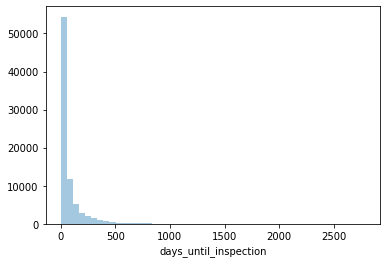

In [170]:
# Original `days_until_inspection`
sns.distplot(complaints["days_until_inspection"], kde = False, bins = 50);

We find a heavily skewed distribution for our target variable, `days_until_inspection`, which is remniscent of an exponential or gamma distribution.

#### Log transformation
Skewed distributions can sometimes be coerced to look more normal using the log transformation. If this is the case with our target, then we may be able to work with a linear regression or other simple model.

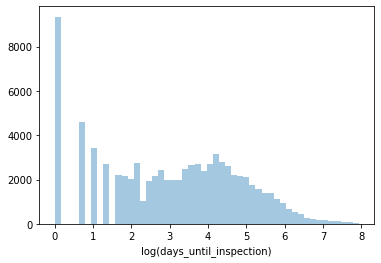

In [171]:
# Log transformed `days_until_inspection`
sns.distplot(np.log(complaints["days_until_inspection"]), axlabel="log(days_until_inspection)", kde = False);

Log transforming our target variable does __not__ result in a normal-looking distribution, so we will keep the target feature as is.

#### Aggregating data by various time intervals

Given the temporal nature of our target, we suspect there are time-related dependencies.

In [172]:
# preparing data for visualization 
complaints_with_time_index = complaints.set_index("date_entered")[["days_until_inspection"]]

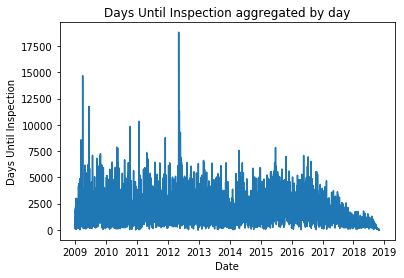

In [173]:
# by day
graph_time_aggregation(
    complaints_with_time_index, 
    "date", 
    "days_until_inspection", 
    "D", 
    "Days Until Inspection aggregated by day"
)

We find after 2016, there appears to be a downward trend in the number of days until a complaint is inspected.

We must consider the recency of the tail end, however, since these complaints are less likely to be "CLOSED" and therefore not seen in the data.

It's difficult to tell if there's any seasonality in these data when aggregating by day.

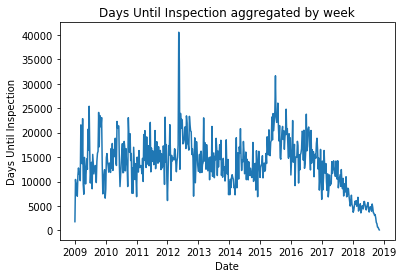

In [174]:
# by week
graph_time_aggregation(
    complaints_with_time_index, 
    "date", 
    "days_until_inspection", 
    "W", 
    "Days Until Inspection aggregated by week"
)

It's difficult to tell if there's any seasonality in these data when aggregating by week.

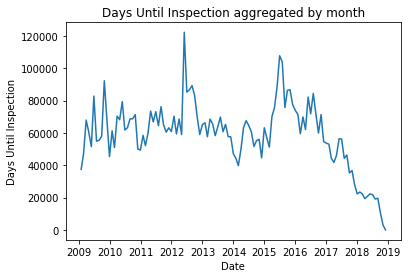

In [175]:
# by month
graph_time_aggregation(
    complaints_with_time_index, 
    "date", 
    "days_until_inspection", 
    "M", 
    "Days Until Inspection aggregated by month"
)

There may be some seasonality by month, though it appears somewhat irregular.

---
We may want to consider testing for seasonality and using an ARIMA or SARIMAX model.

For simplicity, we'll work with average days until inspection by month.

#### Testing for seasonality

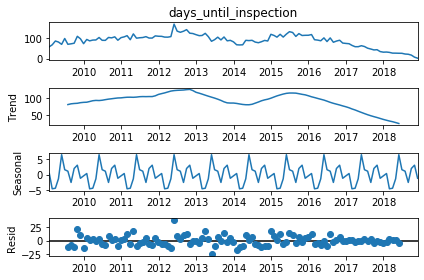

In [176]:
avg_days_until_inspection_by_month = complaints_with_time_index.resample("M").mean()
seasonal_decompose(avg_days_until_inspection_by_month["days_until_inspection"]).plot()
plt.show()

After decomposing the data __we find a seasonal component, which suggests a SARIMAX model may be worth exploring.__

### Exploring Special District

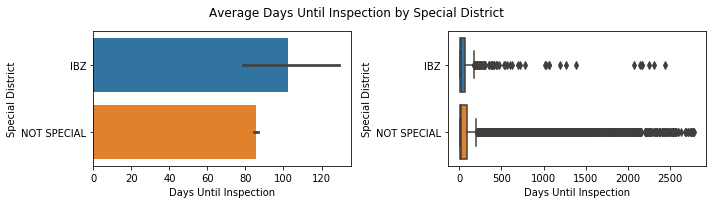

In [177]:
# Special District
aggregation_plots(complaints, "days_until_inspection", "special_district")

__We do not see a significant difference in average `days_until_inspection` between Special Districts,__ however we do see a wide range in individual observations for "NOT SPECIAL" districts.

### Exploring Unit

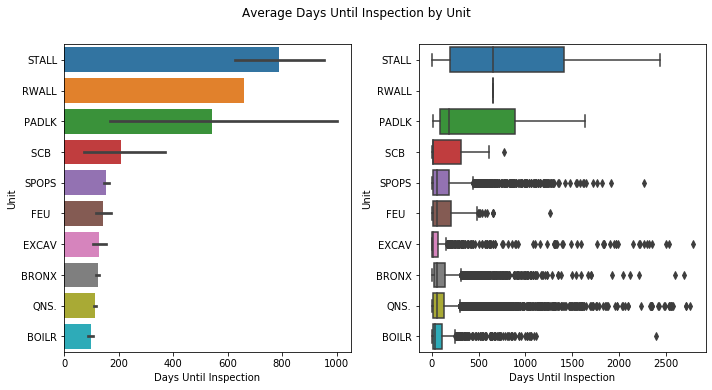

In [178]:
# Unit
aggregation_plots(complaints, "days_until_inspection", "unit")

__The STALL and PADLK units appear to have the longest average days until inspection__ with little different between the other units. Other Units, however, have much more extreme outliers.

### Exploring Complaint Category

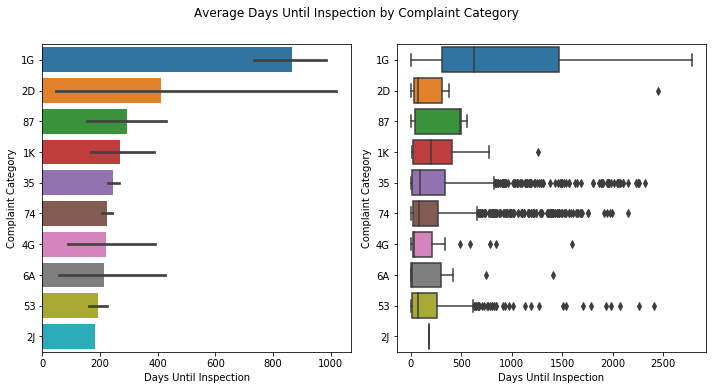

In [179]:
# Complaint Category
aggregation_plots(complaints, "days_until_inspection", "complaint_category")

__The "1G" complaint category appears to take significantly longer to inspect than all other categories,__ even when taking into account the extreme ranges seen in those categories. 

We may want to consider splitting our dataset to handle "1G" and non-"1G" complaint categories.

### Exploring Zip Code

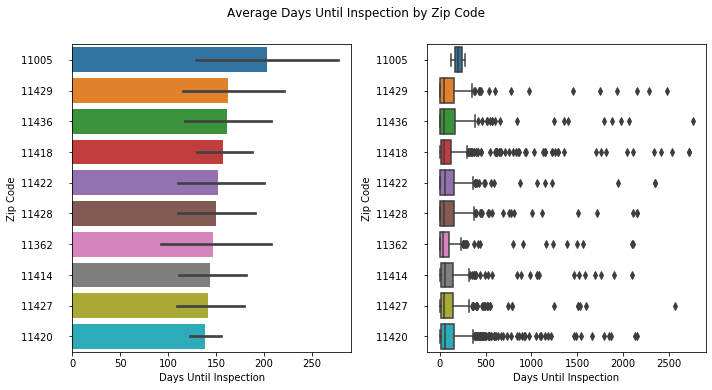

In [180]:
# Zip Code
aggregation_plots(complaints, "days_until_inspection", "zip_code")

Zip Code does not appear to be a significant feature.

In addition, we encountered a number of issues with these data zip codes:
- Many zip codes were missing and while we were able to infer the zip codes, based in the `house_street` and `house_number` and using the Google Maps API, this proved to be impractical.
- A few zip codes also appeared to be outdated. Over time the city of New York has decommissioned some zip codes and created new ones (for example, 11249). Such zip codes were in the dataset, and would require further assumptions to be made.

For these reasons __we'll be removing the Zip Code feature from model consideration.__

### Exploring Median Income

In [181]:
# Median Income by zip code
aggregation_plots(complaints, "days_until_inspection", "med_inc_zip")

KeyError: 'med_inc_zip'

## med_inc_zip interpretation

### Feature Engineering - K-Prototypes Clustering

Since the dataset contains mostly categorical data and some numerical data as well, using a typical clustering algorithm like KMeans will not work (we found using KMeans was ineffective). While we can one-hot encode the categorical columns, this does not give an effective range of numbers to base distances off of, so a more advanced method will be used, KPrototypes. This alogrithm splits the categorical and numerical data apart, and then applies KModes and KMeans, respectively, to the features to create the most appropriate clusters.

#### Preprocessing

We'll select the key features we plan to put into the model and use K-prototypes to create a column of possible clusters as a way of improving model performance.

In [ ]:
# selected features
features = ["special_district", "complaint_category", "unit", "med_inc_zip"]

In [ ]:
complaints_subset = complaints[features]
complaints_subset.head()

#### Searching for best `n_clusters`

In [14]:
kp_objs = []

for i in range(3, 21, 1):
    print("Fitting model with n_clusters =", i)
    n_clusters.append(i)
    kp = KPrototypes(n_clusters=i, n_init=10, random_state=42, n_jobs=-1, verbose=2)
    kp_obj = kp.fit(complaints_subset, categorical=[0, 1, 2, 3])
    kp_objs.append({"obj" : kp_obj, "iter": i, "cost": kp_obj.cost_})

Fitting model with n_clusters = 3
Best run was number 1
Fitting model with n_clusters = 4
Best run was number 7
Fitting model with n_clusters = 5
Best run was number 1
Fitting model with n_clusters = 6
Best run was number 4
Fitting model with n_clusters = 7
Best run was number 1
Fitting model with n_clusters = 8
Best run was number 2
Fitting model with n_clusters = 9
Best run was number 10
Fitting model with n_clusters = 10
Best run was number 9
Fitting model with n_clusters = 11


KeyboardInterrupt: 

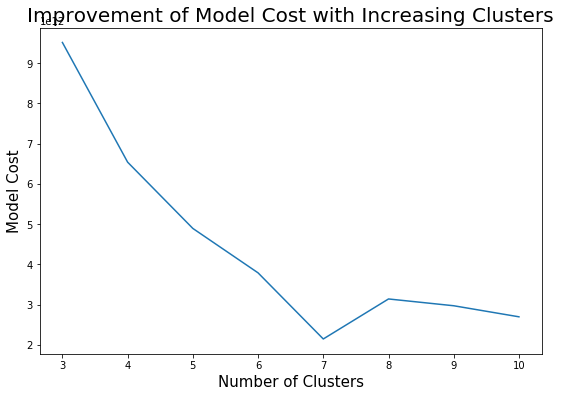

In [26]:
plt.figure(figsize=(9, 6))
plt.plot(range(len(kp_objs)), [kp_obj["cost"] for kp_obj in kp_objs])
plt.title("Improvement of Model Cost with Increasing Clusters", size=20)
plt.xticks(range(len(kp_objs)))
plt.xlabel("Number of Clusters", size=15)
plt.ylabel("Model Cost", size=15);

In [29]:
kp_diffs = [0]
for i, cost in enumerate(kp_model_costs[1:]):
    i_diff = cost - kp_model_costs[i]
    kp_diffs.append(i_diff)

Text(0, 0.5, 'Change in Cost from Previous Model')

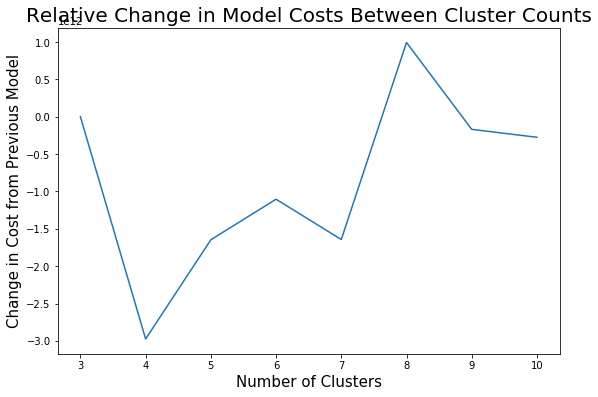

In [32]:
plt.figure(figsize=(9, 6))
plt.plot(range(1, len(kp_objs)), [obj["cost"] - kp_objs[i] for i, obj in enumerate(kp_objs[1:])])
plt.title("Relative Change in Model Costs Between Cluster Counts", size=20)
plt.xticks(range(1, len(kp_objs)))
plt.xlabel("Number of Clusters", size=15)
plt.ylabel("Change in Cost from Previous Model", size=15)

#### Exploring best `n_clusters`

In [38]:
# exploring n_clusters = 4
kp_objs[4]["obj"].cluster_centroids_

[array([[ 83750.00243427],
        [ 60152.13747653],
        [ 38428.95000603],
        [120111.74915825]]), array([['10025', 'NOT SPECIAL', '45', 'QNS.'],
        ['11419', 'NOT SPECIAL', '45', 'QNS.'],
        ['11355', 'NOT SPECIAL', '45', 'BKLYN'],
        ['11215', 'NOT SPECIAL', '05', 'MAN.']], dtype='<U21')]

In [40]:
# exploring n_clusters = 7
kp_objs[7]["obj"].cluster_centroids_

[array([[117942.37745546],
        [243456.02597403],
        [ 32473.05569235],
        [ 47062.06948008],
        [ 57145.36692136],
        [ 67016.08465568],
        [ 84861.95955584]]), array([['11215', 'NOT SPECIAL', '05', 'MAN.'],
        ['10007', 'NOT SPECIAL', '05', 'MAN.'],
        ['11355', 'NOT SPECIAL', '63', 'ELEVR'],
        ['11221', 'NOT SPECIAL', '45', 'BKLYN'],
        ['11216', 'NOT SPECIAL', '45', 'QNS.'],
        ['11419', 'NOT SPECIAL', '45', 'QNS.'],
        ['10025', 'NOT SPECIAL', '05', 'QNS.']], dtype='<U21')]

Running K-Modes and K-Prototypes with the same cluster number, but the additional feature of median income, does give different clusters/centroids. Given the significant increase in processing time between KModes and KPrototypes, it may be more efficient to only use KModes on the categorical features to cluster the datapoints, then integrate the income data as a feature in the final predictive model.

## Model Preperation

In [184]:
target = "days_until_inspection"
features = ["special_district", "complaint_category", "unit"]

X = pd.get_dummies(complaints[features], drop_first = True)
y = complaints[target]

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

## Modeling

First, we'll explore some traditional models, such as Random Forest and Gradient Boost.

Then, we'll see if an ARIMA or SARIMAX model perform better with our time-sensative target variable.

### Random Forest

In [186]:
rf = RandomForestRegressor()

rf_params = {
    "n_estimators": [50],
    "max_depth": [None],
    "max_features": [50]
}

rf_gs = GridSearchCV(rf, rf_params, cv = 5, n_jobs = -1)

rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [187]:
rf_gs.best_params_

{'max_depth': None, 'max_features': 50, 'n_estimators': 50}

In [188]:
# train score
rf_gs.score(X_train, y_train)

0.1593622695478495

In [189]:
# test score
rf_gs.score(X_test, y_test)

0.10972587115605868

In [190]:
# train score
cross_val_score(rf_gs.best_estimator_, X, y).mean()

KeyboardInterrupt: 

Given how underfit our model is with a training $R^2$ of 18% and a testing $R^2$ of 12%, a natural next step would be to try a boosting model.

### Gradient Boost

In [138]:
gb = GradientBoostingRegressor()

gb_params = {
    "n_estimators": [50],
    "max_depth": [None],
    "max_features": [50]
}

gb_gs = GridSearchCV(gb, gb_params, cv = 5, n_jobs = -1)

gb_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [139]:
gs.best_params_

{'max_depth': None, 'max_features': 50, 'n_estimators': 50}

In [140]:
# train score
gs.score(X_train, y_train)

0.18103955564923013

In [141]:
# test score
gs.score(X_test, y_test)

0.12156664792699556

In [142]:
# train score
cross_val_score(gs.best_estimator_, X, y).mean()

0.14311484391805113

Yet again, our model is underfit with a training $R^2$ of 18% and a testing $R^2$ of 12%.

Given the temporal nature of our target and the clear lack of correlation between our features and our target, we'll explor an ARIMA model using only the target.

## ARIMA
We've already seen some seasonality components in our data, which is a motivating reason for exploring a ARIMA model.

### Model Preparation for ARIMA

In [144]:
# ARIMA SETUP
arima_df = complaints.set_index("date_entered")[["days_until_inspection"]].resample("M").mean().dropna().sort_index()

#### Determining `d` using ADF (Augmented Dickey Fuller) Test

We can use the Augmented Dickey Fuller hypothesis test to check for stationarity - a requirement for ARIMA.

In [145]:
# no differencing
result = adfuller(arima_df[target])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.165779
p-value: 0.970276
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


In [147]:
# diff of 1
arima_df_diff_1 = arima_df[target].diff(1).dropna()
result = adfuller(arima_df_diff_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.019269
p-value: 0.000000
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


By __differencing once,__ with a 95% confidence, we reject the null hypothesis accept our data has stationarity (`d = 1`).

#### Determining `p` using autocorrelation function

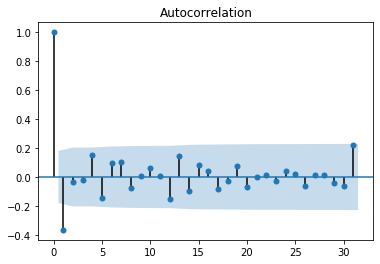

In [150]:
plot_acf(arima_df_diff_1, lags=31)
plt.show()

We find the first positive auto correlation lag is `p = 1`.

#### Determining `q` using partial-autocorrelation function

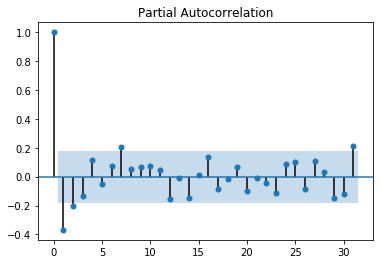

In [151]:
plot_pacf(arima_df_diff_1, lags=31)
plt.show()

The first positive partial-autocorrelation lag is `q = 1`

### Hyperparameter searching using `auto_arima`

To verify our findings, we can use `auto_arima` to gridsearch the best order for our ARIMA model.

In [155]:
fitted_arima = auto_arima(
    arima_df,
    d = 1,
    start_p = 0, start_q = 0,
    seasonal = False
)

In [158]:
fitted_arima.order

(0, 1, 1)

In [240]:
fitted_arima.predict()

## SARIMAX


#### Determining `S`, seasonal component

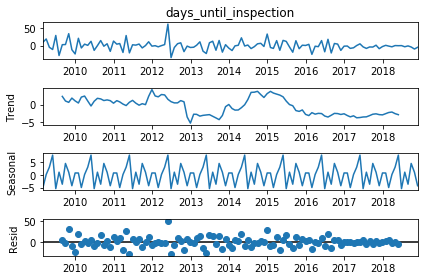

In [152]:
seasonal_decompose(arima_df_diff_1).plot()
plt.show()

We find a strong weekly seasonal component, however the 

### Modeling SARIMAX

In [241]:
sarima = SARIMAX(endog = arima_db.values,
                 order = (p, d, q),
                 seasonal_order = (P, D, Q, S),
                 exog = exog.values
                )

fitted_sarima = sarima.fit()

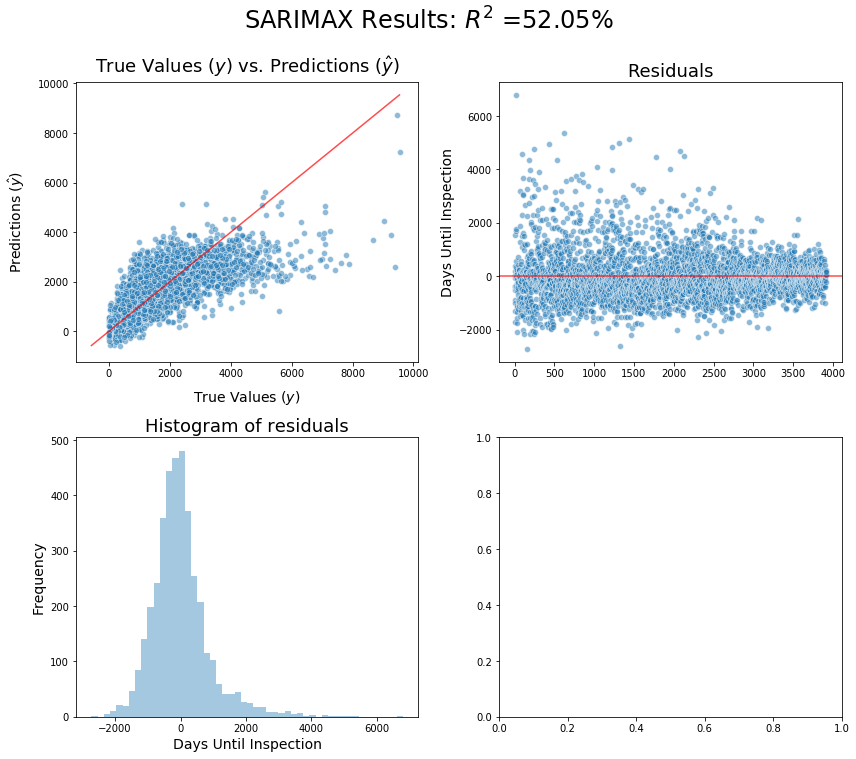

In [242]:
vizResids("SARIMAX Results", "Days Until Inspection", arima_db[target], fitted_sarima.predict(start=0,end=-1))

## Classification Model
By converting target into classes, can simplify model and increase performance

## Model Selection

## Model Evaluation

#### Creating `vizResids` function

`vizResids` is a convenience function to abstract the relevant regression-like model evaluation graphs:
1. True Values ($y$) vs. Predictions ($\hat{y}$)
2. Residuals Plot
3. Residuals Histogram

In [80]:
def vizResids(model_title, target_name,y_true, y_preds):
    resids = y_true - y_preds
    score = r2_score(y_true, y_preds)
    # HANDLING SUBPLOTS
    fig, axes = plt.subplots(2, 2, figsize=(12,10)) # 2 row x 2 columns
    fig.suptitle(f"{model_title}: $R^2$ ={score:2.2%}", fontsize = 24, y = 1.05)

    ax_1 = axes[0][0]
    ax_2 = axes[0][1]
    ax_3 = axes[1][0]

    subplot_title_size = 18
    subplot_label_size = 14
    
    # 1ST PLOT - y_true vs. y_pred
    ax_1.set_title("True Values ($y$) vs. Predictions ($\hat{y}$)", fontsize = subplot_title_size, pad = 10)
    maxDist = max(max(y_preds),max(y_true)) # maxiumum value used to determin x_lim and y_lim
    minDist = min(min(y_preds),min(y_true)) # maxiumum value used to determin x_lim and y_lim
    # 45deg line, signifying prediction == true value
    ax_1.plot((minDist,maxDist),(minDist,maxDist), c = "r", alpha = .7);
    
    sns.scatterplot(ax = ax_1, x = y_true, y = y_preds, alpha = .5)
    ax_1.set_xlabel("True Values ($y$)", fontsize = subplot_label_size, labelpad = 10)
    ax_1.set_ylabel("Predictions ($\hat{y}$)", fontsize = subplot_label_size, labelpad = 10)

    # 2ND PLOT - residuals
    ax_2.set_title("Residuals", fontsize = subplot_title_size)
    sns.scatterplot(ax = ax_2, x = y_preds, y = resids, alpha = .5)
    ax_2.set_ylabel(target_name, fontsize = subplot_label_size)
    ax_2.axhline(0, c = "r", alpha = .7);

    # 3RD PLOT - residuals histogram
    ax_3.set_title("Histogram of residuals", fontsize = subplot_title_size)
    sns.distplot(resids, ax = ax_3, kde = False);
    ax_3.set_xlabel(target_name, fontsize = subplot_label_size)
    ax_3.set_ylabel("Frequency", fontsize = subplot_label_size)

    plt.tight_layout() # handles most overlaping and spacing issues

## Conclusion

## Recommendations

## Resources
- [Data Source](https://data.cityofnewyork.us/Housing-Development/DOB-Complaints-Received/eabe-havv)
- [Complaint Codes](https://www1.nyc.gov/assets/buildings/pdf/complaint_category.pdf)
- [Disposition Codes](https://www1.nyc.gov/assets/buildings/pdf/bis_complaint_disposition_codes.pdf)
- [Data Explains](https://docs.google.com/spreadsheets/d/10p0HLqinKbUrSjKaZC2E0ZTHDXgULT0K/edit#gid=1015257717)